In [1]:
import numpy as np
import math 

from pydrake.common.containers import namedview
from pydrake.systems.framework import (BasicVector,
                                       LeafSystem,
                                       PublishEvent,
                                       AbstractValue,
                                       UnrestrictedUpdateEvent,
                                       WitnessFunctionDirection)

CompassGaitState = namedview('CompassGaitState', ['stance', 'swing', 'stancedot', 'swingdot'])
u_log = []

class CompassGait(LeafSystem):
    def __init__(self, slope, mass_hip):
        LeafSystem.__init__(self)
        
        self.DeclareContinuousState(BasicVector(np.zeros(4)), 2, 2, 0)
        self.DeclareDiscreteState(1)
        
        left_stance = True 
        self.DeclareAbstractState(AbstractValue.Make(left_stance))
        
        self.DeclareVectorOutputPort("minimal", BasicVector(4), self.MinimalStateOut)
        self.DeclareVectorOutputPort("floatingbase", BasicVector(14), self.FloatingBaseStateOut)
        
        self.gravity = 9.81
        self.slope = slope
        
        self.mass_leg = 5
        self.mass_hip = mass_hip
        self.length_leg = 1.0 
        self.center_of_mass_leg = 0.5
        self.distance = self.length_leg - self.center_of_mass_leg
        
        self.count = 0
        
        self.collision_witness = self.MakeWitnessFunction(
            "foot_collision", WitnessFunctionDirection.kPositiveThenNonPositive, 
            self.foot_collision, UnrestrictedUpdateEvent(self.collision_dynamics))
        
    def get_toe_position(self, context):
        return context.get_discrete_state(0).GetAtIndex(0)
    
    def set_toe_position(self, state, value):
#         print ("set_toe_position")
        state.get_discrete_state().get_mutable_vector(0).get_mutable_value()[0]=value
        
    def left_leg_is_stance(self, context):
        return context.get_discrete_state(1).GetAtIndex(0)
    
    def set_left_leg_is_stance(self, state, value):
#         print ("set_left_leg_is_stance")
        state.get_discrete_state().get_mutable_vector(1).get_mutable_value()[0]=value
        
    def foot_collision(self, context):
#         print ("foot_collision")
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        collision = 2*self.slope - c.stance - c.swing
        return max(collision, c.swing - c.stance)
    
    def collision_dynamics(self, context, event, state):
#         print ("collision_dynamics")
        self.new_stance = True 
        
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        next_c = CompassGaitState(context.get_mutable_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        cst = math.cos(c.stance)
        csw = math.cos(c.swing)
        hip_angle = c.swing - c.stance
        ch = math.cos(hip_angle)
        sh2 = math.sin(hip_angle / 2)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
      
        
        M = np.array([[2*m + mh, 0, (m * a + m * l + mh * l) * cst, -m * b * csw], 
                     [0, 2 * m + mh, -(m * a + m * l + mh * l) * sst, m * b * ssw], 
                     [(m * a + m * l + mh * l) * cst, -(m * a + m * l + mh * l) * sst, 
                      m * a * a + (m + mh) * l * l,    -m * l * b * ch], 
                     [-m * b * csw, m * b * ssw, -m * l * b * ch, m * b * b]])
        J = np.array([[1, 0, l * cst,  -l * csw], 
                      [0, 1, -l * sst, l * ssw]])
        
        V_pre = np.array([0, 0, c.stancedot, c.swingdot])
        M_inv = np.linalg.inv(M)
    
        V_post = V_pre - M_inv.dot(J.T).dot(np.linalg.inv(J.dot(M_inv).dot(J.T))).dot(J).dot(V_pre)
        
        next_c.stance = c.swing
        next_c.swing = c.stance
        next_c.stancedot = V_post[3]
        next_c.swingdot = V_post[2]
        
        self.set_toe_position(state, self.get_toe_position(context) - 2 * l * sh2)
#         self.set_left_leg_is_stance(state, abs(self.left_leg_is_stance(context)-1))
        
        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(next_c[:])
        
    def MinimalStateOut(self, context, output):
#         print ("MinimalStateOut")
        x = context.get_continuous_state_vector().CopyToVector()
        y = output.SetFromVector(x)
        
    def FloatingBaseStateOut(self, context, output):
#         print ("FloatingBaseStateOut")
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        toe = self.get_toe_position(context)
        left_stance = True #self.left_leg_is_stance(context)
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        cs = math.cos(self.slope)
        ss = math.sin(self.slope)
        cst = math.cos(c.stance)
        csw = math.cos(c.swing)
        hip_angle = c.swing - c.stance
        ch = math.cos(hip_angle)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
        
        output.SetAtIndex(0, toe * cs + l * sst)
        output.SetAtIndex(1, 0)
        output.SetAtIndex(2, -toe * ss + l * cst)
        
        left = c.stance if left_stance else c.swing 
        right = c.swing if left_stance else c.stance
        
        output.SetAtIndex(3, 0)
        output.SetAtIndex(4, left)
        output.SetAtIndex(5, 0)
        
        output.SetAtIndex(6, right - left)
        
        output.SetAtIndex(7, c.stancedot * l * cst)
        output.SetAtIndex(8, 0)
        output.SetAtIndex(9, -c.stancedot * l * sst)
        
        leftdot = c.stancedot if left_stance else c.swingdot
        rightdot = c.swingdot if left_stance else c.stancedot 

        output.SetAtIndex(10, 0)
        output.SetAtIndex(11, leftdot)
        output.SetAtIndex(12, 0)
        
        output.SetAtIndex(13, rightdot - leftdot)
        
    def DynamicsBiasTerm(self, context):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        g = self.gravity
        s_diff =  math.sin(c.stance - c.swing)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
        vst = c.stancedot
        vsw = c.swingdot
        
        bias = np.array([-m * l * b * vsw * vsw * s_diff - (mh * l + m * (a + l)) * g * sst, 
                         m * l * b * vst * vst * s_diff + m * b * g * ssw])
        
        return bias 
    
    def ControlMatrix(self, context):
        u = 0
        B = np.array([1, -1])
        
        k = self.DoCalcKineticEnergy(context)
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        st_r = c.stance + (90 - self.slope)
        sw_r = c.swing + (90 - self.slope)
        
        st = c.stance
        sw = c.swing
        vst = c.stancedot
        vsw = c.swingdot 
        
#         if self.count < 1500: 
#             if sw > st: 
#                 u = 40*(sw - st)
#             else:
#                 u = 10*(sw - st)
#             self.count += 1 
            
        u_log.append(u)
        return B*u 
        
    def MassMatrix(self, context):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        c_diff = math.cos(c.swing - c.stance)
        
        M = np.array([[mh * l * l + m * (l * l + a * a), -m * l * b * c_diff], 
                      [-m * l * b * c_diff, m * b * b]])
        
        return M 
        
    def DoGetWitnessFunctions(self, context):
#         print ("DoGetWitnessFunctions")
        return [self.collision_witness]

    def DoCalcTimeDerivatives(self, context, derivatives):
#         print ("DoCalcTimeDerivatives")
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        cdot = CompassGaitState(np.zeros(4))
        cdot[0:2] = c[2:4]
        
        M = self.MassMatrix(context)
        bias = self.DynamicsBiasTerm(context)
        B = self.ControlMatrix(context)
        
        a = -np.linalg.inv(M).dot(bias - B) 

        cdot.stancedot = a[0]
        cdot.swingdot = a[1]

        derivatives.get_mutable_vector().SetFromVector(cdot[:])
        
    def DoCalcKineticEnergy(self, context): 
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        vst = c.stancedot
        vsw = c.swingdot 
        
        return 0.5 * (mh * l * l + m * a * a) * vst * vst + 0.5 * m * (l * l * vst * vst + b * b * vsw * vsw) - \
            m * l * b * vst * vsw * math.cos(c.swing - c.stance)
        
    def DoCalcPotentialEnergy(self, context): 
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        g = self.gravity 
        
        y_toe = -self.get_toe_position(context) * math.sin(self.slope)
        y_hip = y_toe + l * math.cos(c.stance)
        
        return m * g * (y_toe + a * math.cos(c.stance)) + mh * g * y_hip + m * g * (y_hip - b * math.cos(c.swing))

In [2]:
import argparse
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (Box,
                         DiagramBuilder,
                         FindResourceOrThrow,
                         FloatingBaseType,
                         Isometry3,
                         RigidBodyTree,
                         RigidBodyPlant,
                         SignalLogger,
                         Simulator,
                         VisualElement)
# from pydrake.examples.compass_gait import (CompassGait, CompassGaitParams)
from underactuated import (PlanarRigidBodyVisualizer)
from IPython.display import HTML

tree = RigidBodyTree("CompassGait.urdf", FloatingBaseType.kRollPitchYaw)

slope = 0.0525 
mass_hip = 10
# slope = 0.01
# mass_hip = 10

R = np.identity(3)
R[0, 0] = math.cos(slope)
R[0, 2] = math.sin(slope)
R[2, 0] = -math.sin(slope)
R[2, 2] = math.cos(slope)
X = Isometry3(rotation=R, translation=[0, 0, -5.])
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.compile()

builder = DiagramBuilder()

compass_gait = builder.AddSystem(CompassGait(slope, mass_hip))

logger = builder.AddSystem(SignalLogger(14))
logger.DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(compass_gait.get_output_port(1), logger.get_input_port(0))

vis = PlanarRigidBodyVisualizer(tree, xlim=[-1., 5.], ylim=[-1., 2.], figsize_multiplier=2)

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)

context = simulator.get_mutable_context()
diagram.Publish(context)  # draw once to get the window open
context.SetAccuracy(1e-4)
context.SetContinuousState([0., 0., 0.4, -2.])
# context.SetContinuousState([0., 0., 0.2, -1.])

total_t = 5.0
simulator.StepTo(total_t)

ani = vis.animate(logger, 60, repeat=True)
plt.close(vis.fig)
HTML(ani.to_html5_video())

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


3459


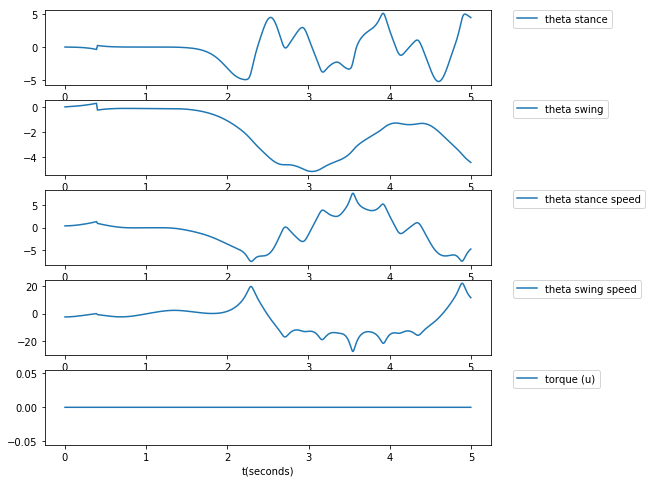

In [3]:
stance_data = logger.data()[9]
swing_data = logger.data()[4]
stancedot_data = logger.data()[11]
swingdot_data = logger.data()[13]

ts = logger.sample_times()
n = len(ts)

print (len(u_log))

step = total_t/len(u_log)
tu = []
for i in range(len(u_log)):
    tu.append(i*step)

ts = ts[:n]
stance_data = stance_data[:n]
swing_data = swing_data[:n]
stancedot_data = stancedot_data[:n]
swingdot_data = swingdot_data[:n]

fig, ax = plt.subplots(5, 1)
fig.set_size_inches(8, 8)
plt.subplot(5, 1, 1)
plt.plot(ts, stance_data, label="theta stance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(5, 1, 2)
plt.plot(ts, swing_data, label="theta swing")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(5, 1, 3)
plt.plot(ts, stancedot_data, label="theta stance speed")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(5, 1, 4)
plt.plot(ts, swingdot_data, label="theta swing speed")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(5, 1, 5)
plt.plot(tu, u_log, label="torque (u)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("t(seconds)");